In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from itertools import product
import datetime

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

# LoadData

In [2]:
ds = pd.read_csv('adult.csv')
print(ds.shape)
ds.head()

(48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
ds['big_income'] = (ds['income']=='>50K').astype(int)
ds['gender_male'] = (ds['gender']=='Male').astype(int)

In [4]:
cat_feats = ['workclass','marital-status','occupation','relationship','race','native-country']
real_feats = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(ds[cat_feats+real_feats],ds['big_income'])

# Train CatBoost

In [6]:
cb_grid_params = {'l2_leaf_reg':[0,3,10,50],
                 'depth':[4,8,12],
                 'learning_rate':[0.03,0.1]}

In [7]:
res_ds_cb = []
l = len(list(product(*cb_grid_params.values())))
for p in tqdm_notebook(product(*cb_grid_params.values()), total=l):
    res = {'l2_leaf_reg':p[0], 'depth':p[1], 'learning_rate':p[2]}
    t0 = datetime.datetime.now()
    cb = CatBoostClassifier(cat_features=cat_feats, **res)
    cb.fit(X_train, Y_train, verbose=False, plot=False)
    preds_train, preds_test = cb.predict_proba(X_train)[:,1], cb.predict_proba(X_test)[:,1]
    auc_train, auc_test = roc_auc_score(Y_train, preds_train), roc_auc_score(Y_test, preds_test)
    t1 = datetime.datetime.now()
    dt = (t1-t0).total_seconds()
    
    res['auc_train'] = auc_train
    res['auc_test'] = auc_test
    res['dt'] = dt
    res_ds_cb.append(res)
res_ds_cb = pd.concat([pd.Series(x) for x in res_ds_cb],1).T
res_ds_cb['model']='CatBoost'
res_ds_cb = res_ds_cb.rename(columns={'l2_leaf_reg':'reg_lambda','depth':'max_depth'})

Training has stopped (degenerate solution on iteration 118, probably too small l2-regularization, try to increase it)


# Train XGBoost

In [8]:
X_train_enc, X_test_enc = X_train.copy(), X_test.copy()
for f in cat_feats:
    le = LabelEncoder()
    X_train_enc[f] = le.fit_transform(X_train[f])
    X_test_enc[f] = le.transform(X_test[f])

In [9]:
xgb_grid_params = {'max_depth':[4,8,12,50],
                    'learning_rate':[0.03, 0.1],
                    'reg_lambda':[0,3,10,50]}

In [10]:
res_ds_xgb = []
l = len(list(product(*xgb_grid_params.values())))
for p in tqdm_notebook(product(*xgb_grid_params.values()), total=l):
    res = {'max_depth':p[0], 'learning_rate':p[1], 'reg_lambda':p[2]}
    t0 = datetime.datetime.now()
    xgb = XGBClassifier(**res)
    xgb.fit(X_train_enc, Y_train)
    preds_train, preds_test = xgb.predict_proba(X_train_enc)[:,1], xgb.predict_proba(X_test_enc)[:,1]
    auc_train, auc_test = roc_auc_score(Y_train, preds_train), roc_auc_score(Y_test, preds_test)
    t1 = datetime.datetime.now()
    dt = (t1-t0).total_seconds()
    
    res['auc_train'] = auc_train
    res['auc_test'] = auc_test
    res['dt'] = dt
    res_ds_xgb.append(res)
res_ds_xgb = pd.concat([pd.Series(x) for x in res_ds_xgb],1).T
res_ds_xgb['model']='XGBoost'

# Analyze results

In [11]:
res_ds = pd.concat([res_ds_cb, res_ds_xgb])

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


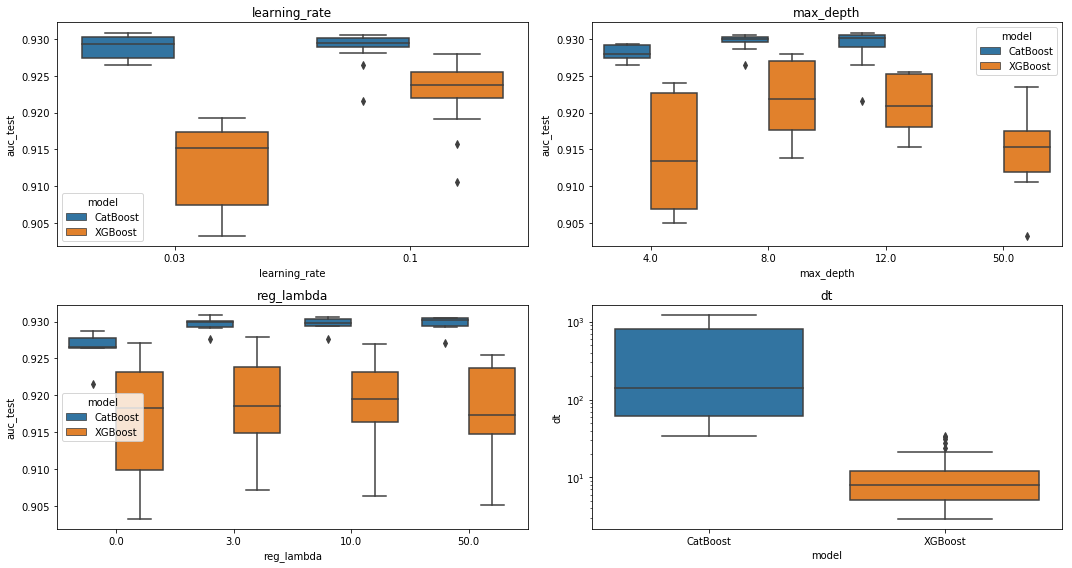

In [34]:
plt.figure(figsize=(15,8))
for idx, f in enumerate(['learning_rate','max_depth','reg_lambda','dt']):
    plt.subplot(2,2,idx+1)
    if f!='dt':
        sns.boxplot(x=f, y='auc_test', hue='model', data=res_ds)
    else:
        sns.boxplot(x='model',y='dt', data=res_ds)
        plt.yscale('log')
    plt.title(f)
plt.tight_layout()
plt.show()